<a href="https://colab.research.google.com/github/zsunberg/ai4all-berkeley-driving/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! git clone https://github.com/zsunberg/ai4all-berkeley-driving
! pip install stable-baselines
! pip install celluloid
! pip install numpy==1.17.0

First, we're going to try and visualize how the effects of different exploration policies on the DQN agent. Run the code below to train a DQN agent that we're going to then play around with. It should take two to three minutes to finish up. It's a pretty long time, but at the end you have a car that can drive! Don't stress out if it's hard to follow, it's just to make things easier for you. On the other hand, if you want to read it, go ahead!

[Errno 2] No such file or directory: 'ai4all-berkeley-driving'
/content/ai4all-berkeley-driving/ai4all-berkeley-driving/ai4all-berkeley-driving/ai4all-berkeley-driving/ai4all-berkeley-driving/ai4all-berkeley-driving


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


908 timesteps
Best mean reward: -inf - Last mean reward per episode: -27.02
Saving new best model
1971 timesteps
Best mean reward: -27.02 - Last mean reward per episode: -25.89
Saving new best model
2996 timesteps
Best mean reward: -25.89 - Last mean reward per episode: -26.86
3972 timesteps
Best mean reward: -25.89 - Last mean reward per episode: -26.22
4950 timesteps
Best mean reward: -25.89 - Last mean reward per episode: -26.71
--------------------------------------
| % time spent exploring  | 91       |
| episodes                | 100      |
| mean 100 episode reward | -26.5    |
| steps                   | 5304     |
--------------------------------------
5928 timesteps
Best mean reward: -25.89 - Last mean reward per episode: -25.82
Saving new best model
6983 timesteps
Best mean reward: -25.82 - Last mean reward per episode: -26.09
7992 timesteps
Best mean reward: -25.82 - Last mean reward per episode: -25.91
8957 timesteps
Best mean reward: -25.82 - Last mean reward per episode:

Text(0, 0.5, 'timesteps')

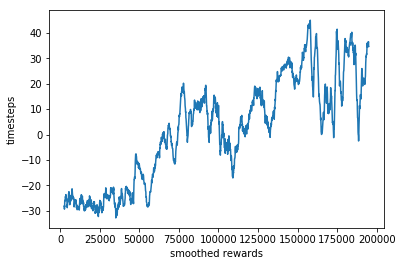

In [22]:
import numpy as np
import os
from stable_baselines import DQN
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy

%cd ai4all-berkeley-driving

import tensorflow

from driving.env import *
from driving.visualization import *

# Train a quick model
best_mean_reward, n_steps = -np.inf, 0
best_mean_reward, n_steps = -np.inf, 0

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

def callback(_locals, _globals):
  """
  Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
  :param _locals: (dict)
  :param _globals: (dict)
  """
  global n_steps, best_mean_reward
  # Print stats every 1000 calls
  if (n_steps + 1) % 1000 == 0:
      # Evaluate policy training performance
      x, y = ts2xy(load_results(log_dir), 'timesteps')
      if len(x) > 0:
          mean_reward = np.mean(y[-100:])
          print(x[-1], 'timesteps')
          print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))

          # New best model, you could save the agent here
          if mean_reward > best_mean_reward:
              best_mean_reward = mean_reward
              # Example for saving best model
              print("Saving new best model")
              _locals['self'].save(log_dir + 'best_model.pkl')
  n_steps += 1
  return True

env = DrivingEnv()
env = Monitor(env, log_dir, allow_early_resets=True)
model = DQN('MlpPolicy', env, verbose=1, tensorboard_log=os.path.join(os.getcwd(), 'tensorboard_logs'),
           exploration_fraction=0.3)
model.learn(total_timesteps=200000, callback=callback)
model.save("deepq_track")
timesteps, reward = ts2xy(load_results(log_dir), 'timesteps')
N = 20
smooth_rew = np.convolve(reward, np.ones((N,))/N, mode='same')
plt.figure()
plt.plot(timesteps[50:-50], smooth_rew[50:-50])
plt.xlabel('smoothed rewards')
plt.ylabel('timesteps')


Lets talk a little bit about exploration. In the previous section, you learned that in Q learning you can find the optimal action by finding the action that maximizes the Q value. That is to say, for every state your Q-function returns the values of the different actions and you just pick the one that has the highest value. 

However, when you're training the model, you want it to try out lots of different states and actions so that it can find the best one. The reason is, before you've trained it, your Q function doesn't actually know what the best action is yet!
Suppose for a second that at some state **s** your Q-function thinks the best action is 0, i.e. turning left 30 degrees. In reality, the best action is 2: not turning at all. If you never try out action 2, you'll never find that out! So, we use what's known as an **exploration policy.**

Instead of just taking the action the Q function wants you to take, you occasionally just take a random action and see how it does. In the following code, we define a value **exploration_prob** that defines how often we take the Q value versus taking a totally random action. If **exploration_prob** is high, we'll take a random action more often, if it's low we'll take the action chosen by the Q function more often. Play around with it and see how the behavior changes!



/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


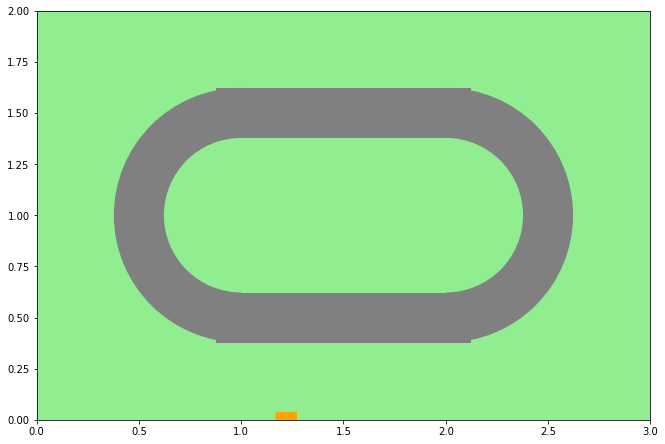

In [21]:
env = DrivingEnv()
model = DQN.load(log_dir + 'best_model', env)
# Play around with this value! How does changing exploration_prob affect how the car drives?
exploration_prob = 0.02
def explore(x, y, theta):
    prob = np.random.uniform(1)
    if prob > max(min(exploration_prob, .999), 0):
      best_a = model.predict([x,y,theta])[0]
      return env.actions[best_a]
    else:
      return env.actions[np.random.randint(len(env.actions))]
x = animate(env, explore, dt=0.2)
x

Now we have a trained policy, lets actually use it for selecting actions! For your convenience, I've defined a function that returns the "value" of each of the actions. Given what we've learned about how DQN selects actions, try to figure out a way to use these methods for action selection. Once you've finished, go down to cells and see how your controller does!

In [27]:
def return_action_probs(x, y, theta)
    return model.action_probability([2, 0, 0])

def policy(x, y, theta):
    # Fill this in here. Your function should take in the x, y, theta and return a value between 0 and 8.
    # Be sure to use the return_action_probs function, it should be helpful.
    

array([0.4650252 , 0.36451337, 0.0575038 , 0.00761697, 0.10534068],
      dtype=float32)

In [0]:
x = animate(env, policy, dt=0.2)
x